# Yelp Exploration

In [12]:
%matplotlib inline

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

## Data Import

The datasets are large, so we will import each one in separate cells (just in case we only want to run parts of the notebook).

In [2]:
%%time
# reviews = pd.read_csv('input/yelp_review.csv') # will take over 2 minutes
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000) # essentially instant

Wall time: 367 ms


In [3]:
%%time
businesses = pd.read_csv('input/yelp_business.csv')

Wall time: 910 ms


In [4]:
%%time
attributes = pd.read_csv('input/yelp_business_attributes.csv', 
                             dtype='category', na_values='Na', true_values='True', false_values='False')
attribute_names = attributes.drop('business_id', axis=1).columns
attributes[attribute_names] = attributes[attribute_names].apply(lambda x: x.cat.codes)

Wall time: 2.86 s


The raw attributes have a lot of Na's.  Also certain columns are not pure True/False.  For now we'll just use the category codes so that we can actually convert to integers.

## EDA

In [10]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


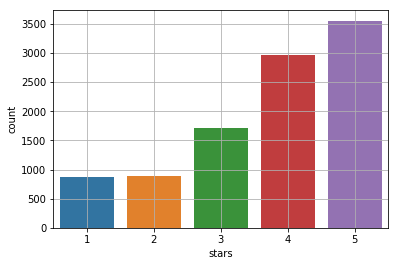

In [5]:
sns.countplot('stars', data=reviews)
plt.grid()
plt.show()

For geographical separation.  We can run KMeans or put this on a maps API later.

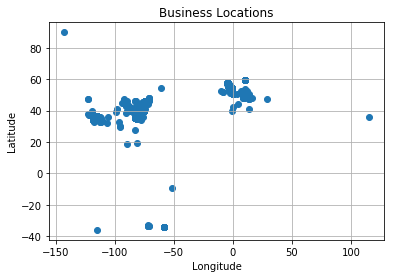

In [81]:
plt.scatter(businesses.longitude, businesses.latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Business Locations')
plt.grid()
plt.show()

We're going to join businesses and attributes now.  Businesses without listed attributes and the converse will be excluded by the inner join.

In [30]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Extracting Categories

The categories in the `businesses` data frame is useful to us.  However, it is currently in the form of semicolon separated values.  In addition, the categories for each business do not seem to be ordered in any way.  Consider that restaurants are probably the most popular type of business on Yelp, but the "restaurant" label is not necessarily first (or even near the top) of the category list for any given applicable business.  Therefore, we will do some preprocessing to extract all the categories and sort them by popularity, i.e. frequency of appearance in businesses.

In [39]:
c = Counter()
joined.categories.str.split(';').apply(lambda x: c.update(x))

print('Total number of business: %d' % joined.shape[0])

n_categories = len(c.keys())
print('Total number of categories: %d' % n_categories)

Total number of business: 152041
Total number of categories: 1269


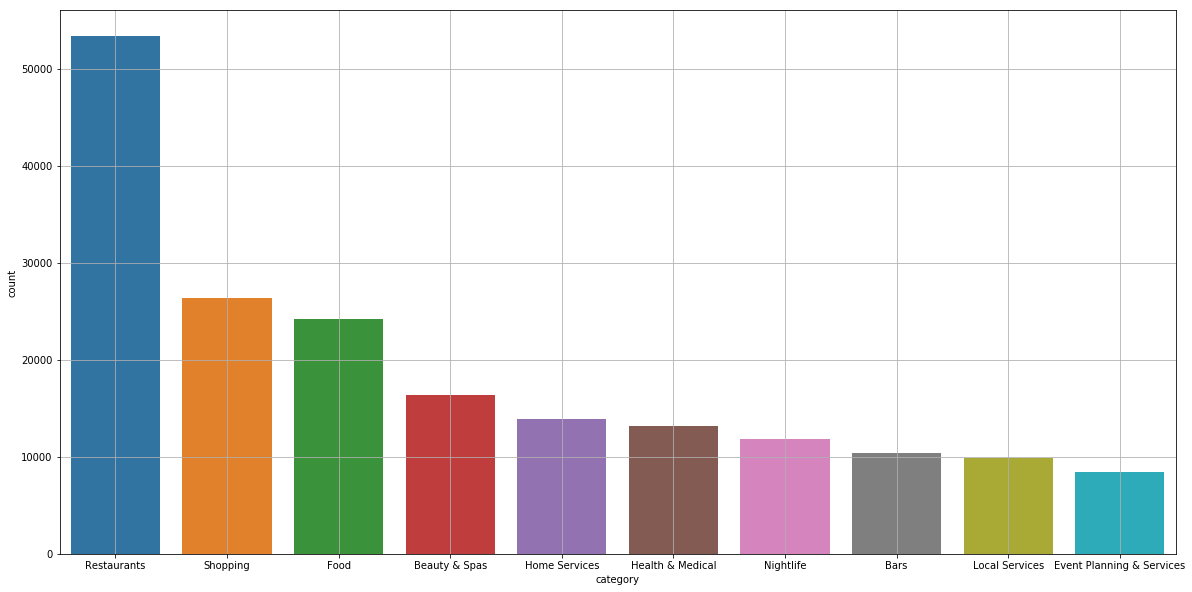

In [57]:
categories = pd.DataFrame.from_dict(c, orient='index').reset_index()
categories.columns = ['category', 'count']
categories = categories.sort_values('count', ascending=False)

plt.figure(figsize=[20,10])
sns.barplot(x='category', y='count', data=categories.iloc[:10])
plt.grid()
plt.show()

Now, we want to pull out the first few categories as "main categories for each business.  To do this, we

1. Split the categories
2. Sort the categories by descending count
3. Rejoin the categories
4. Split the categories into separate columns
5. Extract the first 3 columns

Admitedly, there seems to be some inefficiency between steps 3 and 4.  I am currently unsure of how to do it better.

In [67]:
main_categories = joined.categories.str.split(';')\
    .apply(lambda row: ';'.join(sorted(row, key=lambda x:-c[x]))).\
    str.split(';', expand=True)\
    [[0,1,2]]

main_categories.columns = ['category1', 'category2', 'category3']
attributes_categories = pd.concat([joined, main_categories], axis=1)
attributes_categories.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService,category1,category2,category3
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,Health & Medical,Dentists,General Dentistry
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,Beauty & Spas,Hair Salons,Hair Stylists
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,Shopping,Sporting Goods,None
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Nightlife,Bars
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Italian,None


## Machine Learning

### Predicting Star with Business Attributes

I'm getting lazy with the naming convention here.  I'll have to fix the `X_train` vs `train_data` naming convention later.  For now, I just need to differentiate between training on the reviews and training on the business attributes.  Also, I'm going to just treat dev and test as the same for now since so most people online seem to do that anyways.

Also, the categories column is valuable but is currently unusable as a semicolon separated string value.  I'll deal with this later.

In [68]:
np.random.seed(0)
X_train_attr, X_test_attr, y_train_attr, y_test_attr = \
    train_test_split(joined[attribute_names].values, joined.stars.astype(np.int8).values, test_size=.1)

#### Decision Tree

In [70]:
%%time

dt = DecisionTreeClassifier()
dt.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, dt.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.333     0.002     0.004       528
          2      0.429     0.041     0.075      2130
          3      0.419     0.386     0.402      4992
          4      0.371     0.632     0.467      5275
          5      0.368     0.228     0.282      2280

avg / total      0.393     0.386     0.347     15205

Wall time: 1.31 s


#### Random Forest

In [71]:
%%time

rf = RandomForestClassifier()
rf.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, rf.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000       528
          2      0.439     0.042     0.077      2130
          3      0.419     0.387     0.402      4992
          4      0.371     0.631     0.467      5275
          5      0.368     0.228     0.282      2280

avg / total      0.383     0.386     0.347     15205

Wall time: 2.2 s


C:\Users\David\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Naive Bayes

In [73]:
%%time

nb = MultinomialNB()
nb.fit(X_train_attr+1, y_train_attr) # have to add 1 to X_train_attr because NB doesn't like negative numbers

print(metrics.classification_report(y_test_attr, nb.predict(X_test_attr+1), digits=3))

             precision    recall  f1-score   support

          1      0.104     0.036     0.054       528
          2      0.311     0.088     0.137      2130
          3      0.426     0.380     0.402      4992
          4      0.392     0.406     0.399      5275
          5      0.292     0.575     0.387      2280

avg / total      0.367     0.366     0.349     15205

Wall time: 268 ms


### Predicting Stars with Review Text

In this section we will predict the star rating associated with each review text.

In [5]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1)

#### Count Vectorizer

In [6]:
%%time
cv = CountVectorizer(stop_words='english')
dtm_train = cv.fit_transform(X_train_review)
dtm_test = cv.transform(X_test_review)
print('Number of features from CountVectorizer: %d' % len(cv.get_feature_names()))

lr = LogisticRegression()
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

Number of features from CountVectorizer: 30044
             precision    recall  f1-score   support

          1      0.694     0.628     0.659        94
          2      0.377     0.299     0.333        87
          3      0.384     0.303     0.339       175
          4      0.460     0.513     0.485       300
          5      0.611     0.663     0.636       344

avg / total      0.513     0.520     0.515      1000

Wall time: 8.17 s


#### TFIDF Vectorizer

In [7]:
%%time
tv = TfidfVectorizer(stop_words='english')
dtm_train2 = tv.fit_transform(X_train_review)
dtm_test2 = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

lr2 = LogisticRegression()
lr2.fit(dtm_train2, y_train_review)

print(metrics.classification_report(y_test_review, lr2.predict(dtm_test), digits=3))

Number of features from TFIDFVectorizer: 30044
             precision    recall  f1-score   support

          1      0.716     0.564     0.631        94
          2      0.276     0.333     0.302        87
          3      0.338     0.434     0.380       175
          4      0.491     0.527     0.508       300
          5      0.737     0.587     0.654       344

avg / total      0.551     0.518     0.529      1000

Wall time: 2.53 s


TFIDF has both a better F1 score and is faster.  We will continue just using TFIDF instead of keeping two vectorizers.

In [8]:
# rename some variables
dtm_train = dtm_train2
dtm_test = dtm_test2
lr = lr2

#### Optimizing Logistic Regression

We now do some searching for the best parameters for logistic regression in order to maximize accuracy.

In [9]:
%%time

lr = GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], 'C': [.02, .2, 2]})
lr.fit(dtm_train, y_train_review)
print('\nLogistic Regression, best parameters: ' + str(lr.best_params_))
print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))


Logistic Regression, best parameters: {'C': 2, 'penalty': 'l1'}
             precision    recall  f1-score   support

          1      0.727     0.681     0.703        94
          2      0.419     0.207     0.277        87
          3      0.441     0.297     0.355       175
          4      0.476     0.533     0.503       300
          5      0.607     0.733     0.664       344

avg / total      0.534     0.546     0.532      1000

Wall time: 7.42 s


#### SVM

We will be using a linear SVC as the C-support SVC scales quadratically with training size, making it unfeasible to train on the entire reviews set.

In [10]:
%%time
svc = LinearSVC()
svc.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.678     0.649     0.663        94
          2      0.382     0.241     0.296        87
          3      0.383     0.326     0.352       175
          4      0.453     0.497     0.474       300
          5      0.623     0.683     0.652       344

avg / total      0.514     0.523     0.516      1000

Wall time: 488 ms


In [11]:
%%time
svc = GridSearchCV(LinearSVC(), {'C': [.02, .2, 2]})
svc.fit(dtm_train, y_train_review)
print('\nSVC, best parameters: ' + str(svc.best_params_))
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))


SVC, best parameters: {'C': 0.2}
             precision    recall  f1-score   support

          1      0.706     0.638     0.670        94
          2      0.459     0.195     0.274        87
          3      0.431     0.286     0.344       175
          4      0.475     0.530     0.501       300
          5      0.614     0.762     0.680       344

avg / total      0.535     0.548     0.531      1000

Wall time: 2.21 s


#### Naive Bayes

In [13]:
%%time
nb = MultinomialNB()
nb.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000        94
          2      0.000     0.000     0.000        87
          3      0.000     0.000     0.000       175
          4      0.370     0.400     0.385       300
          5      0.442     0.869     0.586       344

avg / total      0.263     0.419     0.317      1000

Wall time: 101 ms


C:\Users\David\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
%%time
nb = GridSearchCV(MultinomialNB(), {'alpha': [.002, .02, .2, 2]})
nb.fit(dtm_train, y_train_review)
print('\nMultinomial Naive Bayes, best parameters: ' + str(nb.best_params_))
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))


Multinomial Naive Bayes, best parameters: {'alpha': 0.02}
             precision    recall  f1-score   support

          1      0.630     0.489     0.551        94
          2      0.192     0.057     0.088        87
          3      0.364     0.246     0.294       175
          4      0.414     0.513     0.458       300
          5      0.569     0.680     0.620       344

avg / total      0.460     0.482     0.462      1000

Wall time: 293 ms


Naive Bayes works really poorly unless we decrease Laplace smoothing (default value is 1).

### Binarizing the Labels

It would be difficult for even a human to perfectly predict a review's star rating just from the text.  This is especially true for the middle star ratings, where language may be less dramatic.  Therefore, we will now divide all the reviews into two categories (negative and positive) and see how well machine learning can differentiate between the two.

We are going to filter out the 3 star reviews.  Then, we treat the 1- and 2-star reviews as negative; the 4- and 5-star reviews as positive.

In [20]:
extreme_reviews = reviews[['text', 'stars']][reviews.stars != 3]
extreme_reviews['positive'] = extreme_reviews.stars > 3
extreme_reviews.head()

,text,stars,positive
0,Super simple place but amazing nonetheless. It...,5,True
1,Small unassuming place that changes their menu...,5,True
2,Lester's is located in a beautiful neighborhoo...,5,True
3,Love coming here. Yes the place always needs t...,4,True
4,Had their chocolate almond croissant and it wa...,4,True


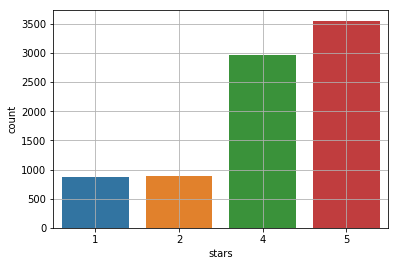

In [21]:
sns.countplot('stars', data=extreme_reviews)
plt.grid()
plt.show()

We will train the classifiers using the best parameters found in the previous sections.

In [25]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(extreme_reviews.text.values, extreme_reviews.positive.values, test_size=.1)
    
tv = TfidfVectorizer(stop_words='english')
dtm_train = tv.fit_transform(X_train_review)
dtm_test = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

Number of features from TFIDFVectorizer: 26985


In [26]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.942     0.670     0.783       194
       True      0.907     0.987     0.946       635

avg / total      0.915     0.913     0.908       829

Wall time: 125 ms


In [27]:
%%time

svc = LinearSVC(C=.2)
svc.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.952     0.608     0.742       194
       True      0.892     0.991     0.939       635

avg / total      0.906     0.901     0.893       829

Wall time: 52 ms


In [28]:
%%time

nb = MultinomialNB(alpha=.02)
nb.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.867     0.469     0.609       194
       True      0.858     0.978     0.914       635

avg / total      0.860     0.859     0.842       829

Wall time: 8 ms


As expected performance is now much better.  The algorithm is able to tell the difference between positive and negative reviews with over 90% accuracy in the case of logistic regression.  Logistic regression seems to be performing the best among the three candidate models, so we will continue with that.